## <center><ins>Trabajo Práctico 2: Críticas cinematográficas</ins></center>
#### <center>*Ensambles*</center>
##### <center>75.06 / 95.58 Organización de Datos - FIUBA</center>
##### <center>Ing. Rodríguez - 1°C 2023</center>
---
#### <center>**Grupo 31 - "Datazo":**</center>
<center> Michael Mena - 102685</center>
<center>Pablo Brocca - 104256</center>
<center>Diego Kisinovsky - 106203</center>

---
---

## Carga de datos y librerías

In [58]:
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Metricas
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Clasificadores
from xgboost import XGBClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline

# Optimización de hiperparámetros
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Categorical

# Manejo de modelos
from pickle import dump
from pickle import load

# Configuración de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Emsables
from collections import defaultdict
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
import plotly.graph_objects as go
%matplotlib inline

### Lectura del dataset de entrenamiento

In [59]:
df = pd.read_csv('../input/dataset/train_preprocesado.csv', sep=',', header=0)
df.drop('longitud', axis=1,inplace=True)
df.head()

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,1
1,Una pequeña pequeña producción.La técnica de f...,1
2,Pensé que esta era una manera maravillosa de p...,1
3,"Básicamente, hay una familia donde un niño peq...",0
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


### Carga stopwords

In [60]:
sw = pd.read_csv('../input/dataset/my-stop-words.csv')['palabra'].to_list() # 390 palabras, 77 nuevas agregadas a mano y 308 de NLTK

print(f'Cantidad de stopwords: {len(sw)}')

Cantidad de stopwords: 390


### Definición de funciones

In [61]:
#Funcion para evaluar los modelos
def evaluate_model(model, x, y, splits=5, repeats=1, metric='f1'):
    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=1)
    scores = cross_val_score(model, x, y, scoring=metric, cv=cv, verbose=1, n_jobs=-1, error_score='raise')
    return scores

In [62]:
def bar_plot_results(model_scores, name):
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    means = [np.mean(result) for result in results]
    errors = [np.std(result) for result in results]
    fig = go.Figure()
    for model, mean, error in zip(model_names, means, errors):
        fig.add_trace(go.Bar(
            x=[model],
            y=[mean],
            name=model,
            error_y=dict(
                type='data',
                array=[error],
                visible=True,
                color='black',
                thickness=1,
                width=5
            )
        ))
    
    fig.update_layout(
        title='Score de Accuracy de cada modelo usando 5-Fold Cross-Validation',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        xaxis_title='Model',
        yaxis_title='Accuracy',
        showlegend=False
    )
    fig.show()

### Importacion de modelos:

In [63]:
model_bn = load(open('/kaggle/input/model-alt/modelo_bayes_stacking.pkl', 'rb'))
model_rf = load(open('/kaggle/input/model-alt/modelo_rf.pkl', 'rb'))
model_xgb = load(open('/kaggle/input/model-alt/modelo_xgb.pkl', 'rb'))

## Armado y entrenamiento

### Preparación de features:

In [64]:
target = 'sentimiento'

# Se elimina el target del las features
features = df.columns.tolist()
features.remove(target)
features = features[0]
features

'review_es'

### Train-Test Split:

In [65]:
x_train, x_test, y_train, y_test = train_test_split(df[features], 
                                                    df[target], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df[target],
                                                    shuffle=True)

# Verificamos cantidad de datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

# Verificamos como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 40000
# Datos Prueba: 10000
% Positivos Entrenamiento: 50.000
% Positivos Prueba: 50.000


In [66]:
vectorizer = TfidfVectorizer(smooth_idf=True, # Suaviza el IDF al agregar 1 a todos los documentos, como si hubiera un documento más con todas las palabras del vocabulario
                                    norm='l1', # Normalización por filas (cada fila suma 1)
                                    strip_accents='unicode', # Remueve acentos y tildes
                                    max_features=20000, # Si se quiere usar el vocabulario completo, quitar este parámetro (selecciona las n-gramas más frecuentes)
                                    sublinear_tf=True, # Reemplaza tf por 1 + log(tf), puede ayudar a reducir la importancia de las palabras 
                                    #muy frecuentes que tienden a dominar el cálculo de las ponderaciones
                                    analyzer='word', stop_words=sw, 
                                    ngram_range=(1, 1) )

# (1,1) unigramas, (2,2) bigramas y (3,3) trigramas, (1,3) los tres mencionados anteriormente. A mayor ngram_range, más features (amplia el vocabulario)

In [67]:
x_train_vectorizer = vectorizer.fit_transform(x_train)

#### Entrenamiento y evaluación de modelos:
Se evaluarán los siguientes modelos:
- Bayes Naïve
- Random Forest
- XGBoost

Cada uno de los modelos se evaluará utilizando una estrategia de validación cruzada de cinco folds repetida dos veces. En cada iteracion cada modelo se entrenó en el 80 % de los datos y se validó en el 20 % restante.

Este método da como resultado 10 puntajes de performance diferentes para cada modelo que se almacenarán en un diccionario.

In [71]:
base_model = {'BN': model_bn, 'RF': model_rf, 'XGB': model_xgb}

#Guadamos los resultados de las métricas de cada modelo
model_scores = defaultdict()

# Entrenamos los clasificadores
for name, model in base_model.items():
    print('Entrenando modelo: {}'.format(name))
    scores = evaluate_model(model, x_train_vectorizer, y_train)
    model_scores[name] = scores

### Stacking

#### Armamos el emsamble con StackingCVClassifier, que utiliza como estimador final un LogisticRegression.

In [72]:
#Modelos bases
base_models = [('BN', model_bn), ('RF', model_rf), ('XGB', model_xgb)]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensamble con stacking
model_stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, verbose=1, n_jobs=-1)

model_stacking.fit(x_train_vectorizer, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.7min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 37.8min finished


StackingClassifier(cv=5,
                   estimators=[('BN',
                                MultinomialNB(alpha=0.09548678852073982,
                                              fit_prior=False)),
                               ('RF',
                                RandomForestClassifier(ccp_alpha=8.157894736842105e-05,
                                                       max_depth=120,
                                                       min_samples_leaf=7,
                                                       min_samples_split=12,
                                                       n_estimators=590,
                                                       n_jobs=-1)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=N...
                                              interaction_constraints=None,
                                              learning_rate=0.14, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=60,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=360, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegressionCV(), n_jobs=-1,
                   verbose=1)

In [75]:
x_pred_vect = vectorizer.transform(x_test)

y_pred = model_stacking.predict(x_pred_vect)

accuracy_score(y_test, y_pred)

0.8794

---

## Análisis del modelo Stacking

##### Algunas definiciones:

- **TP (True Positives):** Cantidad de clasificaciones positivas correctas

- **TN (True Negatives):** Cantidad de clasificaciones negativas correctas

- **FN (False Negatives):** Cantidad de clasificaciones negativas incorrectas

- **FP (False Positives):** Cantidad de clasificaciones positivas incorrectas


- **Precison = TP/TP+FP**\
    Porcentaje de valores clasificados como positivos que son realmente positivos

- **Recall/TPR (True Positive Rate) = TP/TP+FN**\
    Porcentaje de valores positivos que fueron correctamente clasificados

- **FPR (False Positive Rate) = FP/FP+TN**\
    Proporción de casos negativos clasificados como positivos

- **F1 Score = 2 * ( (precision * recall) / (precision + recall) )**\
    Métrica que combina precision y recall para un valor más objetivo

- **Support**\
    Cantidad de ocurrencias de cada clase en el split de test

#### Reporte de clasificación y matriz de confusión para Stacking:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5000
           1       0.88      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Text(50.722222222222214, 0.5, 'True')

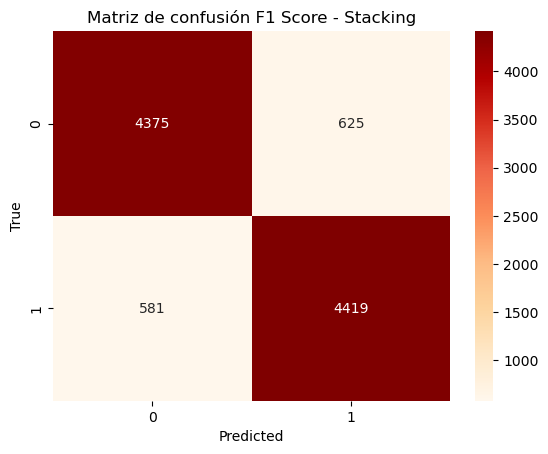

In [76]:
# Reporte y Matriz de Confusion
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='OrRd',annot=True,fmt='g')
plt.title("Matriz de confusión F1 Score - Stacking")
plt.xlabel('Predicted')
plt.ylabel('True')

#### Comparamos todos los modelos

In [90]:
# Evaluamos los scores de stacking
stacking_scores = evaluate_model(model_stacking, x_train_vectorizer, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 |

In [91]:
print(stacking_scores)

[0.87411281 0.87937259 0.88167227 0.87766024 0.86954365]


In [92]:
model_scores

defaultdict(None,
            {'stacking': array([0.87411281, 0.87937259, 0.88167227, 0.87766024, 0.86954365])})

In [93]:
# Graficamos los resultados
bar_plot_results(model_scores, name='model_stacking_cv')

---

## Aplicación de modelos al dataset de test

##### Lectura del dataset de test original para mantener id:

In [80]:
df_test = pd.read_csv('../input/dataset/test_preprocesado.csv', sep=',', header=0)

##### Predicción y exportación:

In [84]:
y_pred_final = model_stacking.predict(vectorizer.transform(df_test[features]))

In [85]:
# Mapear etiquetas a valores numéricos
# label_mapping = {'negativo': 0, 'positivo': 1}
# y_pred_final_numeric = np.array([label_mapping[label] for label in y_pred_final])

# Calcular las frecuencias
counts = np.bincount(y_pred_final)
count_1 = counts[1]  # Frecuencia de positivos
count_0 = counts[0]  # Frecuencia de negativos

print("Resultado de la predicción: ")
print("Positivos: ", count_1)
print("Negativos: ", count_0)

Resultado de la predicción: 
Positivos:  4910
Negativos:  3689


In [86]:
# Mapeo de prediccion numerica a etiqueta (positivo, negativo)
y_pred_final = np.where(y_pred_final == 1, 'positivo', 'negativo')

In [89]:
pd.concat([df_test['ID'],pd.DataFrame(data=y_pred_final, columns=['sentimiento'])], axis=1).to_csv('/kaggle/working/pred_stacking.csv', index=False)

---

## Exportación de modelos

In [88]:
dump(model_stacking, open('/kaggle/working/model_stacking.pkl', 'wb'))

---